In [1]:
# Just testing my Spatial AE

import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision

from torch.utils.data import TensorDataset, DataLoader, random_split

#from tqdm.autonotebook import tqdm, trange

from utils.models import *
from utils.model_tools import *
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

!pwd

Using cuda device
/home/maggie/predictive-coding-thesis/src


In [14]:
from utils.data_processing import remove_consecutive_repeats

data = remove_consecutive_repeats('data/frames_worldone_2023-11-13-01-25-33.npy')
close = np.isclose(data[1], data[0])
print(close.shape)
print(np.where(~close))



352
333
(128, 128, 3)
(array([  0,   0,   0, ..., 123, 123, 123]), array([ 49,  65,  85, ..., 105, 105, 105]), array([1, 1, 0, ..., 0, 1, 2]))


In [4]:
torch.manual_seed(321)

model_file = 'model_files/worldone_fixedhead.pt'

# need to consider if you actually want to transform
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_dir = 'data'
target_dir_name = 'worldone-indexed/frames'

dataset = SequentialFrameDataset(source_directory=data_dir, 
                                 target_directory_name=target_dir_name,
                                 transform=transform)

train_ratio = math.floor(len(dataset) * 0.9)
train_data, test_data = random_split(dataset, [train_ratio, len(dataset) - train_ratio])
print(f'{train_ratio} training samples')
batch_size = 16
# does it matter in this instance if you shuffle? I think you can get away with it
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

print(torch.cuda.memory_allocated(device))

Indexing files to data/worldone-indexed/frames


KeyboardInterrupt: 

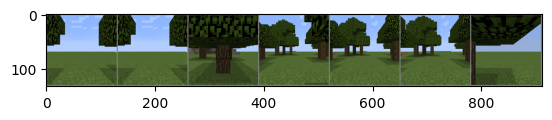

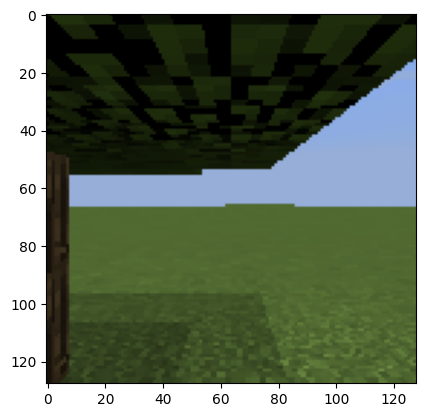

In [4]:
# Take a look at the sequence of images

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

seq, preds = next(iter(train_loader))
imshow(torchvision.utils.make_grid(seq[0]))
imshow(preds[0])

In [5]:
model = PredictiveCoder()
model.to(device)
print(len(train_loader))

num_epochs = 200 # in the actual example this will be 200
steps_per_epoch = len(train_loader) #?

learning_rate = 0.1
weight_decay = 5 * 10**-6

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=steps_per_epoch)


2698


In [6]:
train_losses_file = 'logs/spatial-ae-fixedhead-ep200-train.txt'
test_losses_file = 'logs/spatial-ae-fixedhead-ep200-test.txt'

train_losses = []
test_losses = []
#t = trange(num_epochs)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_fn, optimizer, device)
    test_loss = test(test_loader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch} train loss: {test_loss}')
    #t.set_description(f"Epoch {epoch} train loss: {epoch_loss_train[-1]:.3f}")
    lr_scheduler.step()
    
torch.save(model.state_dict(), model_file)

with open(train_losses_file, 'w') as fp:
    for s in train_losses:
        fp.write("%s\n" % s)
        
with open(test_losses_file, 'w') as fp:
    for x in test_losses:
        fp.write("%s\n" % x)

print("Done!")


Epoch 1
-------------------------------
start enc 330460160
end enc 1588869120
start enc 1588869120
end enc 2847278080
start enc 2847278080
end enc 4105687040
start enc 4105687040
end enc 5364096000
start enc 5364096000


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacty of 5.93 GiB of which 44.88 MiB is free. Including non-PyTorch memory, this process has 5.66 GiB memory in use. Of the allocated memory 5.37 GiB is allocated by PyTorch, and 216.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Train an MLP to predict location from latent values

In [7]:
# Load in the coordinate data

data_dir = 'data'
target_dir_name = 'worldone-indexed'

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CoordinateDataset(source_directory=data_dir, 
                            target_directory_name=target_dir_name,
                            transform=transform)

train_ratio = math.floor(len(dataset) * 0.9)
train_data, test_data = random_split(dataset, [train_ratio, len(dataset) - train_ratio])
print(f'{train_ratio} training samples')
batch_size = 16
# does it matter in this instance if you shuffle? I think you can get away with it
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

Indexing files to data/worldone-indexed/frames


OSError: 393216 requested and 61312 written

In [ ]:
train_losses_file = 'logs/pred-loc-fixedhead-train.txt'
test_losses_file = 'logs/pred-loc-fixedhead-test.txt'

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_fn, optimizer, device)
    test_loss = test(test_loader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch} train loss: {test_loss}')
    lr_scheduler.step()
    
torch.save(model.state_dict(), model_file)

with open(train_losses_file, 'w') as fp:
    for s in train_losses:
        fp.write("%s\n" % s)
        
with open(test_losses_file, 'w') as fp:
    for x in test_losses:
        fp.write("%s\n" % x)

print("Done!")


In [37]:
import datetime

directory = 'data/'
coordinates = set()

for file in os.listdir(directory):
    if file.startswith('coords_'):
        data = np.load(os.path.join(directory, file))
        # Assuming the data format in each file is [x, y, yaw]
        for line in data:
            x, z = line[0], line[1]
            coordinates.add((x, z))

print(len(coordinates))
print(40*65) # minus any obstacles, but should be kinda close

full_coords = set()
for x in range(-484,-427):
    for z in range(-694, -658):
        full_coords.add((x + 0.5, z + 0.5))

#print(full_coords.difference(coordinates))
# TODO remove duplicate entries from your training data

1952
2600


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming we have two sets of data points, one for actual (ground truth) and one for predicted
# For demonstration, random points around a line y=x will be generated for actual
# and points with some added noise for predicted

np.random.seed(0) # for reproducibility

# Generate some random data for demonstration purposes
actual_x = np.linspace(-40, 40, 300)
actual_y = actual_x + np.random.normal(size=actual_x.shape) * 5  # some random noise around the line y=x

predicted_x = actual_x + np.random.normal(size=actual_x.shape) * 5  # additional noise for predicted points
predicted_y = actual_y + np.random.normal(size=actual_y.shape) * 5

# Calculate errors (distance) between actual and predicted points
errors_x = predicted_x - actual_x
errors_y = predicted_y - actual_y
errors = np.sqrt(errors_x**2 + errors_y**2)

# Create the figure and the axis
fig, ax = plt.subplots()

# Plot actual points
ax.scatter(actual_x, actual_y, color='gray', label='Actual')

# Plot predicted points
ax.scatter(predicted_x, predicted_y, color='blue', label='Predicted')

# Plot error lines
for i in range(len(actual_x)):
    ax.plot([actual_x[i], predicted_x[i]], [actual_y[i], predicted_y[i]], color='gray', linewidth=0.5)

# Set labels and title
ax.set_xlabel('x (lattice units)')
ax.set_ylabel('y (lattice units)')
ax.set_title('The predictive coder\'s latent space encodes spatial position')

# Add legend
ax.legend()

# Show the plot
plt.show()
